In [ ]:
from collections import Counter, defaultdict
from typing import List, Dict, Literal, Union

import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from gensim.models.phrases import Phrases, Phraser

from datasets import load_dataset
from sentence_transformers import SentenceTransformer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
RANDOM_STATE = 42

**LOAD THE DATASET**

In [3]:
ds = load_dataset("UniverseTBD/arxiv-abstracts-large")
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi', 'report-no', 'categories', 'license', 'abstract', 'versions', 'update_date', 'authors_parsed'],
        num_rows: 2292057
    })
})

In [4]:
# Print 3 first examples
for i in range(3):
    print(f"Example {i+1}:")
    print(ds["train"][i]['abstract'])
    print(ds["train"][i]['categories'])
    print("---" * 20)

Example 1:
  A fully differential calculation in perturbative quantum chromodynamics is
presented for the production of massive photon pairs at hadron colliders. All
next-to-leading order perturbative contributions from quark-antiquark,
gluon-(anti)quark, and gluon-gluon subprocesses are included, as well as
all-orders resummation of initial-state gluon radiation valid at
next-to-next-to-leading logarithmic accuracy. The region of phase space is
specified in which the calculation is most reliable. Good agreement is
demonstrated with data from the Fermilab Tevatron, and predictions are made for
more detailed tests with CDF and DO data. Predictions are shown for
distributions of diphoton pairs produced at the energy of the Large Hadron
Collider (LHC). Distributions of the diphoton pairs from the decay of a Higgs
boson are contrasted with those produced from QCD processes at the LHC, showing
that enhanced sensitivity to the signal can be obtained with judicious
selection of events.

hep-p

In [5]:
# Print all categories 
all_categories = ds["train"]["categories"]
print(len(all_categories))

2292057


In [6]:
# Primary categories (unique values)
category_set = set()

# Collect unique labels
for category in all_categories:
    parts = category.split(" ")
    for part in parts:
        topic = part.split(".")[0]
        category_set.add(topic)

# Sort the labels and print them
sorted_categories = sorted(list(category_set), key=lambda x: x.lower())
print(f"There are {len(sorted_categories)} unique primary categories in the dataset:")

for category in sorted_categories:
    print(category)

There are 38 unique primary categories in the dataset:
acc-phys
adap-org
alg-geom
ao-sci
astro-ph
atom-ph
bayes-an
chao-dyn
chem-ph
cmp-lg
comp-gas
cond-mat
cs
dg-ga
econ
eess
funct-an
gr-qc
hep-ex
hep-lat
hep-ph
hep-th
math
math-ph
mtrl-th
nlin
nucl-ex
nucl-th
patt-sol
physics
plasm-ph
q-alg
q-bio
q-fin
quant-ph
solv-int
stat
supr-con


In [7]:
# Load 1000 samples with single label belonging to specific categories
samples = []
CATEGORIES_TO_SELECT = ["astro-ph", "cond-mat", "cs", "math", "physics"]

for s in ds["train"]:
    if len(s["categories"].split(" ")) != 1:
        continue

    cur_category = s["categories"].strip().split(".")[0]
    if cur_category not in CATEGORIES_TO_SELECT:
        continue
    samples.append(s)
    
    if len(samples) >= 1000:
        break

print(f"Number of samples: {len(samples)}")

Number of samples: 1000


**PREPROCESSING THE DATA**

In [8]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [9]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [ ]:
preprocessed_samples = []

for s in samples:
    abstract = s["abstract"]
    
    # Remove \n characters in the middle and leading/trailing spaces
    abstract = abstract.strip().replace("\n", " ")
    
    # Remove special characters
    abstract = re.sub(r"[^\w\s]", "", abstract)
    
    # Remove digits
    abstract = re.sub(r'\d+', '', abstract)
    
    # Remove extra spaces
    abstract = re.sub(r'\s+', ' ', abstract).strip()
    
    # Convert to lower case
    abstract = abstract.lower()

    # Tokenize and Lemmatize
    tokens = nltk.word_tokenize(abstract)
    lemmatized_tokens = []

    for word, tag in nltk.pos_tag(tokens):
        pos = get_wordnet_pos(tag)
        lemmatized_tokens.append(lemmatizer.lemmatize(word, pos))

    abstract = " ".join(lemmatized_tokens)
    
    # For the label, we only keep the first part
    parts = s["categories"].split(" ")
    category = parts[0].split(".")[0]
    
    preprocessed_samples.append({
        "text": abstract,
        "label": category
    })

In [10]:
# Experiment

preprocessed_samples = []
texts_for_phrases = []

for s in samples:
    abstract = s["abstract"]

    # Remove \n characters in the middle and leading/trailing spaces
    abstract = abstract.strip().replace("\n", " ")

    # Remove special characters
    abstract = re.sub(r"[^\w\s]", "", abstract)

    # Remove digits
    abstract = re.sub(r'\d+', '', abstract)

    # Remove extra spaces
    abstract = re.sub(r'\s+', ' ', abstract).strip()

    # Convert to lower case
    abstract = abstract.lower()

    # Tokenize and lemmatize
    tokens = nltk.word_tokenize(abstract)
    lemmatized_tokens = []
    for word, tag in nltk.pos_tag(tokens):
        pos = get_wordnet_pos(tag)
        lemmatized_tokens.append(lemmatizer.lemmatize(word, pos))

    # Collect tokens for phrase detection training
    texts_for_phrases.append(lemmatized_tokens)

    # For the label, we only keep the first part
    parts = s["categories"].split(" ")
    category = parts[0].split(".")[0]

    preprocessed_samples.append({
        "text_tokens": lemmatized_tokens, # Store tokens for now
        "label": category
    })

# Train the phrase detection model
phrases = Phrases(texts_for_phrases, min_count=5, threshold=10) # Adjust parameters as needed
phraser = Phraser(phrases)

# Apply the phrase detection model to the tokens
for sample in preprocessed_samples:
    phrased_tokens = phraser[sample["text_tokens"]]
    sample["text"] = " ".join(phrased_tokens) # Add the 'text' key with joined phrases
    del sample["text_tokens"] # Remove the temporary 'text_tokens' key

In [11]:
# Create 2 dictionaries to store primary categories
label_to_id = {label: i for i, label in enumerate(CATEGORIES_TO_SELECT)}
id_to_label = {i: label for i, label in enumerate(CATEGORIES_TO_SELECT)}

# Print label to ID mapping
print("Label to ID mapping:")
for label, id_ in label_to_id.items():
    print(f"{label} --> {id_}")

Label to ID mapping:
astro-ph --> 0
cond-mat --> 1
cs --> 2
math --> 3
physics --> 4


In [12]:
# Train/test split
X_full = [sample["text"] for sample in preprocessed_samples]
y_full = [label_to_id[sample["label"]] for sample in preprocessed_samples]

X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2,
    random_state=RANDOM_STATE, stratify=y_full
)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training samples: 800
Test samples: 200


**SENTENCE EMBEDDINGS**

In [13]:
class EmbeddingVectorizer:
    def __init__(
        self,
        model_name: str = "intfloat/multilingual-e5-large",
        #model_name: str = "intfloat/multilingual-e5-base",
        normalize: bool = True,
        device: Union[str, None] = None
    ):
        self.device = device
        self.model = SentenceTransformer(model_name, device=self.device)
        self.normalize = normalize

    def _format_inputs(
        self,
        texts: List[str],
        mode: Literal['query', 'passage']
    ) -> List[str]:
        if mode not in {"query", "passage"}:
            raise ValueError("Mode must be either 'query' or 'passage'")
        return [f"{mode}: {text.strip()}" for text in texts]

    def transform(
        self,
        texts: List[str],
        mode: Literal['query', 'passage'] = 'query'
    ) -> List[List[float]]:
        if mode == 'raw':
            inputs = texts
        else:
            inputs = self._format_inputs(texts, mode)

        embeddings = self.model.encode(inputs, normalize_embeddings=self.normalize)
        return embeddings.tolist()

    def transform_numpy(
        self,
        texts: List[str],
        mode: Literal['query', 'passage'] = 'query'
    ) -> np.ndarray:
        return np.array(self.transform(texts, mode=mode))

In [14]:
# Initialize Bag-of-Words
bow_vectorizer = CountVectorizer()
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

In [15]:
# Initialize TfIdf
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [16]:
# Initialize embedding vectorizer
embedding_vectorizer = EmbeddingVectorizer()
X_train_embeddings = embedding_vectorizer.transform(X_train)
X_test_embeddings = embedding_vectorizer.transform(X_test)

Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

In [17]:
# Convert all to numpy arrays for consistency
X_train_bow, X_test_bow = np.array(X_train_bow.toarray()), np.array(X_test_bow.toarray())

X_train_tfidf, X_test_tfidf = np.array(X_train_tfidf.toarray()), np.array(X_test_tfidf.toarray())

X_train_embeddings, X_test_embeddings = np.array(X_train_embeddings), np.array(X_test_embeddings)

In [18]:
# Print shapes of the transformed datasets
print(f"Shape of X_train_bow: {X_train_bow.shape}")
print(f"Shape of X_test_bow: {X_test_bow.shape}\n")
print(f"Shape of X_train_tfidf: {X_train_tfidf.shape}")
print(f"Shape of X_test_tfidf: {X_test_tfidf.shape}\n")
print(f"Shape of X_train_embeddings: {X_train_embeddings.shape}")
print(f"Shape of X_test_embeddings: {X_test_embeddings.shape}\n")

Shape of X_train_bow: (800, 9348)
Shape of X_test_bow: (200, 9348)

Shape of X_train_tfidf: (800, 9348)
Shape of X_test_tfidf: (200, 9348)

Shape of X_train_embeddings: (800, 1024)
Shape of X_test_embeddings: (200, 1024)



**TRAINING MODELS**

**KMeans Clustering**

In [19]:
def train_and_test_kmeans(X_train, y_train, X_test, y_test, n_clusters: int):
    kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE)
    clusters_ids = kmeans.fit_predict(X_train)

    # Assign label to clusters
    cluster_to_label = {}
    for cluster_id in set(clusters_ids):
        # Get all labels in this cluster
        labels_in_cluster = [y_train[i] for i in range(len(y_train)) if clusters_ids[i] == cluster_id]
        most_common_label = Counter(labels_in_cluster).most_common(1)[0][0]
        cluster_to_label[cluster_id] = most_common_label

    # Predict labels for test set
    test_cluster_ids = kmeans.predict(X_test)
    y_pred = [cluster_to_label[cluster_id] for cluster_id in test_cluster_ids]
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(
        y_test, y_pred,
        target_names=[id_to_label[i] for i in range(len(id_to_label))],
        output_dict=True
    )

    return y_pred, accuracy, report

In [20]:
# Train and test K-Means of different vectorized datasets
km_bow_labels, km_bow_accuracy, km_bow_report = train_and_test_kmeans(
    X_train_bow, y_train, 
    X_test_bow, y_test,
    n_clusters=len(label_to_id)
)

km_tfidf_labels, km_tfidf_accuracy, km_tfidf_report = train_and_test_kmeans(
    X_train_tfidf, y_train,
    X_test_tfidf, y_test,
    n_clusters=len(label_to_id)
)

km_embeddings_labels, km_embeddings_accuracy, km_embeddings_report = train_and_test_kmeans(
    X_train_embeddings, y_train,
    X_test_embeddings, y_test,
    n_clusters=len(label_to_id)
)

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined 

In [21]:
# Print K-Means results
print("Accuracies for K-Means:")
print(f"Bag of Words: {km_bow_accuracy:.4f}")
print(f"TF-IDF: {km_tfidf_accuracy:.4f}")
print(f"Embeddings: {km_embeddings_accuracy:.4f}")

Accuracies for K-Means:
Bag of Words: 0.5350
TF-IDF: 0.7750
Embeddings: 0.8200


In [22]:
# Plot confusion matrix for each method
def plot_confusion_matrix(
    y_true, y_pred, label_list,
    figure_name="Confusion Matrix",
    save_path=None
):
    """
    Plots a confusion matrix with raw counts and normalized values using Seaborn.
    
    Parameters:
        y_true (array-like): True class labels.
        y_pred (array-like): Predicted class labels.
        label_list (list or dict): Class names (list or dict from ID to name).
        figure_name (str): Title of the plot.
        save_path (str, optional): Path to save the figure. If None, the figure will not be saved.
    """
    # Compute confusion matrix and normalize
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Map class indices to names
    labels = np.unique(y_true)
    if isinstance(label_list, dict):
        class_names = [label_list[i] for i in labels]
    else:
        class_names = [label_list[i] for i in labels]
    
    # Create annotations with raw + normalized values
    annotations = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            raw = cm[i, j]
            norm = cm_normalized[i, j]
            annotations[i, j] = f"{raw}\n({norm:.2%})"

    # Plot
    plt.figure(figsize=(6, 4))
    sns.heatmap(
        cm, annot=annotations, fmt="", cmap="Blues",
        xticklabels=class_names, yticklabels=class_names,
        cbar=False, linewidths=1, linecolor='black'
    )
    
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(figure_name)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)

    plt.show()

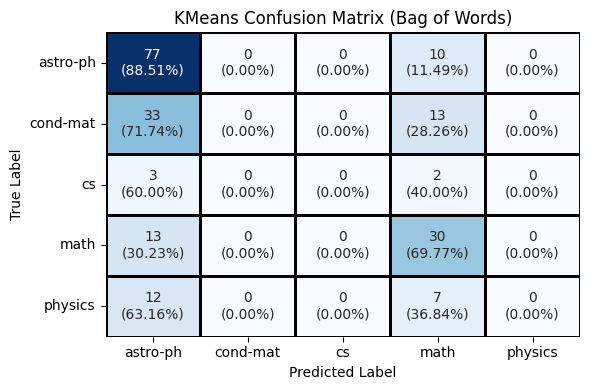

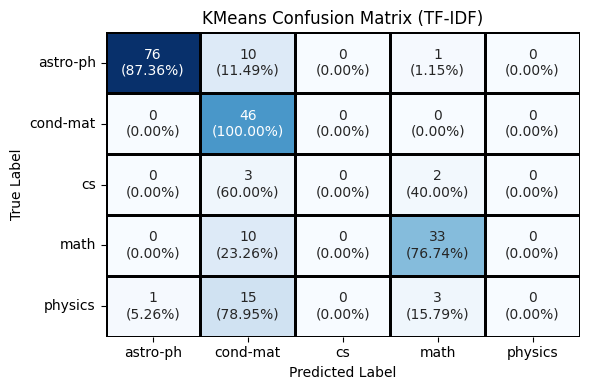

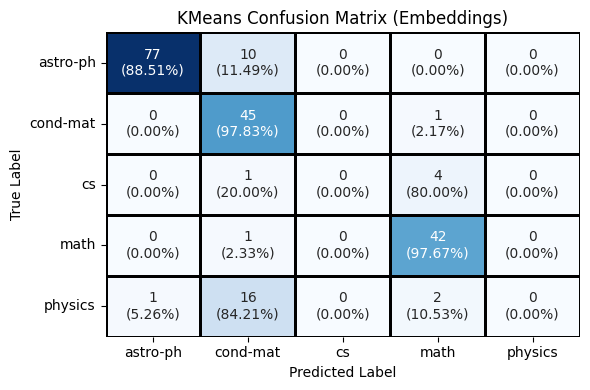

In [23]:
# Draw confusion matrices
plot_confusion_matrix(
    y_test, km_bow_labels, id_to_label, 
    "KMeans Confusion Matrix (Bag of Words)"
)

plot_confusion_matrix(
    y_test, km_tfidf_labels, id_to_label, 
    "KMeans Confusion Matrix (TF-IDF)"
)

plot_confusion_matrix(
    y_test, km_embeddings_labels, id_to_label, 
    "KMeans Confusion Matrix (Embeddings)"
)

**K-Nearest Neighbors (KNN)**

In [24]:
def train_and_test_knn(X_train, y_train, X_test, y_test, n_neighbors: int = 5):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)

    # Predict on the test set
    y_pred = knn.predict(X_test)
    
    # Calculate accuracy and classification report
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(
        y_test, y_pred,
        target_names=id_to_label,
        output_dict=True
    )
    
    return y_pred, accuracy, report

In [25]:
# Train and test KNN of different vectorized datasets
knn_bow_labels, knn_bow_accuracy, knn_bow_report = train_and_test_knn(
    X_train_bow, y_train, 
    X_test_bow, y_test
)

knn_tfidf_labels, knn_tfidf_accuracy, knn_tfidf_report = train_and_test_knn(
    X_train_tfidf, y_train,
    X_test_tfidf, y_test
)

knn_embeddings_labels, knn_embeddings_accuracy, knn_embeddings_report = train_and_test_knn(
    X_train_embeddings, y_train,
    X_test_embeddings, y_test
)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classif

In [26]:
# Print KNN results
print("Accuracies for KNN:")
print(f"Bag of Words: {knn_bow_accuracy:.4f}")
print(f"TF-IDF: {knn_tfidf_accuracy:.4f}")
print(f"Embeddings: {knn_embeddings_accuracy:.4f}")

Accuracies for KNN:
Bag of Words: 0.5700
TF-IDF: 0.8500
Embeddings: 0.8500


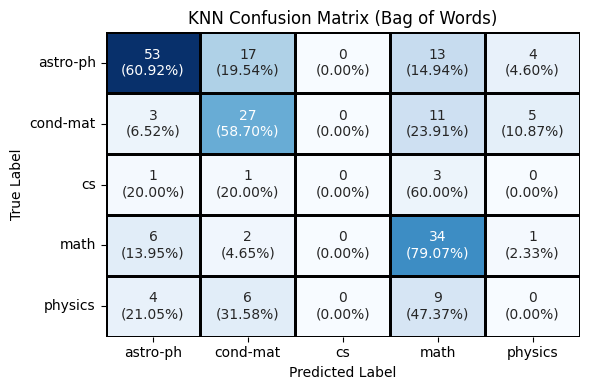

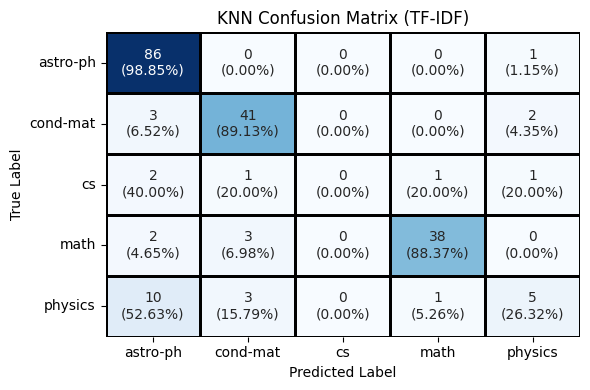

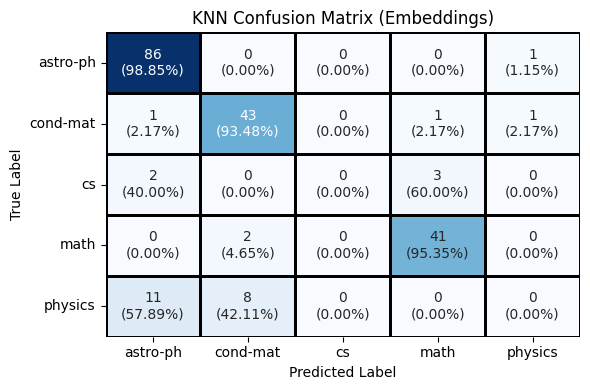

In [27]:
# Draw confusion matrices
plot_confusion_matrix(
    y_test, knn_bow_labels, id_to_label, 
    "KNN Confusion Matrix (Bag of Words)"
)

plot_confusion_matrix(
    y_test, knn_tfidf_labels, id_to_label, 
    "KNN Confusion Matrix (TF-IDF)"
)

plot_confusion_matrix(
    y_test, knn_embeddings_labels, id_to_label, 
    "KNN Confusion Matrix (Embeddings)"
)

**Decision Tree**

In [28]:
def train_and_test_decision_tree(X_train, y_train, X_test, y_test):
    dt = DecisionTreeClassifier(
        criterion='gini',
        splitter='best',
        random_state=RANDOM_STATE
    )
    dt.fit(X_train, y_train)

    # Predict on the test set
    y_pred = dt.predict(X_test)
    
    # Calculate accuracy and classification report
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(
        y_test, y_pred,
        target_names=id_to_label,
        output_dict=True
    )
    
    return y_pred, accuracy, report

In [29]:
# Train and test Decision Tree of different vectorized datasets
dt_bow_labels, dt_bow_accuracy, dt_bow_report = train_and_test_decision_tree(
    X_train_bow, y_train, 
    X_test_bow, y_test
)

dt_tfidf_labels, dt_tfidf_accuracy, dt_tfidf_report = train_and_test_decision_tree(
    X_train_tfidf, y_train,
    X_test_tfidf, y_test
)

dt_embeddings_labels, dt_embeddings_accuracy, dt_embeddings_report = train_and_test_decision_tree(
    X_train_embeddings, y_train,
    X_test_embeddings, y_test
)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
# Print Decision Tree results
print("Accuracies for Decision Tree:")
print(f"Bag of Words: {dt_bow_accuracy:.4f}")
print(f"TF-IDF: {dt_tfidf_accuracy:.4f}")
print(f"Embeddings: {dt_embeddings_accuracy:.4f}")

Accuracies for Decision Tree:
Bag of Words: 0.6050
TF-IDF: 0.6100
Embeddings: 0.6000


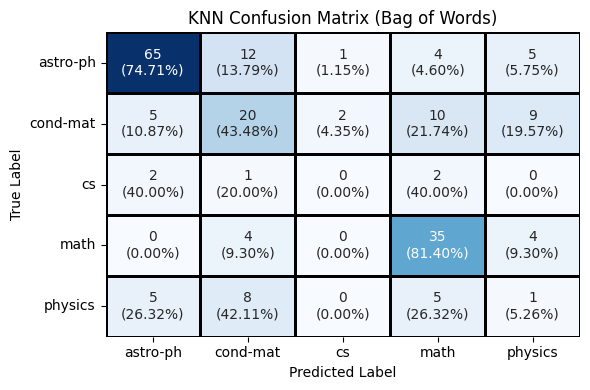

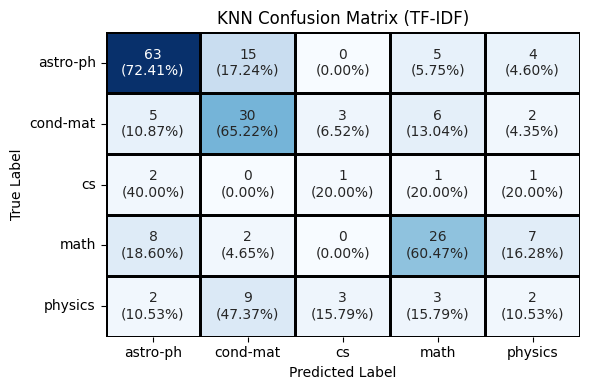

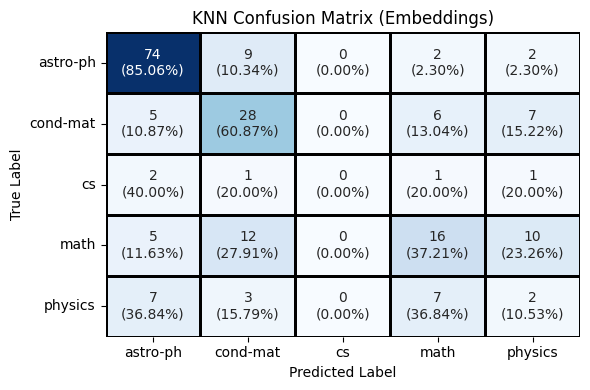

In [31]:
# Draw confusion matrices
plot_confusion_matrix(
    y_test, dt_bow_labels, id_to_label, 
    "KNN Confusion Matrix (Bag of Words)"
)

plot_confusion_matrix(
    y_test, dt_tfidf_labels, id_to_label, 
    "KNN Confusion Matrix (TF-IDF)"
)

plot_confusion_matrix(
    y_test, dt_embeddings_labels, id_to_label, 
    "KNN Confusion Matrix (Embeddings)"
)

**RESULTS**

In [32]:
# Print K-Means results
print("Accuracies for K-Means:")
print(f"Bag of Words: {km_bow_accuracy:.4f}")
print(f"TF-IDF: {km_tfidf_accuracy:.4f}")
print(f"Embeddings: {km_embeddings_accuracy:.4f}")

Accuracies for K-Means:
Bag of Words: 0.5350
TF-IDF: 0.7750
Embeddings: 0.8200


In [33]:
# Print KNN results
print("Accuracies for KNN:")
print(f"Bag of Words: {knn_bow_accuracy:.4f}")
print(f"TF-IDF: {knn_tfidf_accuracy:.4f}")
print(f"Embeddings: {knn_embeddings_accuracy:.4f}")

Accuracies for KNN:
Bag of Words: 0.5700
TF-IDF: 0.8500
Embeddings: 0.8500


In [34]:
# Print Decision Tree results
print("Accuracies for Decision Tree:")
print(f"Bag of Words: {dt_bow_accuracy:.4f}")
print(f"TF-IDF: {dt_tfidf_accuracy:.4f}")
print(f"Embeddings: {dt_embeddings_accuracy:.4f}")

Accuracies for Decision Tree:
Bag of Words: 0.6050
TF-IDF: 0.6100
Embeddings: 0.6000


Accuracies for K-Means:
Bag of Words: 0.5500
TF-IDF: 0.7100
Embeddings: 0.8100

Accuracies for KNN:
Bag of Words: 0.5350
TF-IDF: 0.8150
Embeddings: 0.8700

Accuracies for Decision Tree:
Bag of Words: 0.6350
TF-IDF: 0.5950
Embeddings: 0.6350